In [1]:
from keras.preprocessing.image import ImageDataGenerator 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense , Flatten , Conv2D 
from keras.layers import  MaxPooling2D ,BatchNormalization , Dropout
import cv2 as cv


In [2]:
w_h = 75
train_datagen = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)
valid_dategen = ImageDataGenerator(rescale = 1./255)

In [3]:
training_set = train_datagen.flow_from_directory('Train',
                                                 target_size = (w_h, w_h),
                                                 batch_size = 16,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('Test',
                                            target_size = (w_h, w_h),
                                            batch_size = 32,
                                            class_mode = 'binary')
valid_set =  valid_dategen.flow_from_directory('Validation',
                                            target_size = (w_h, w_h),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


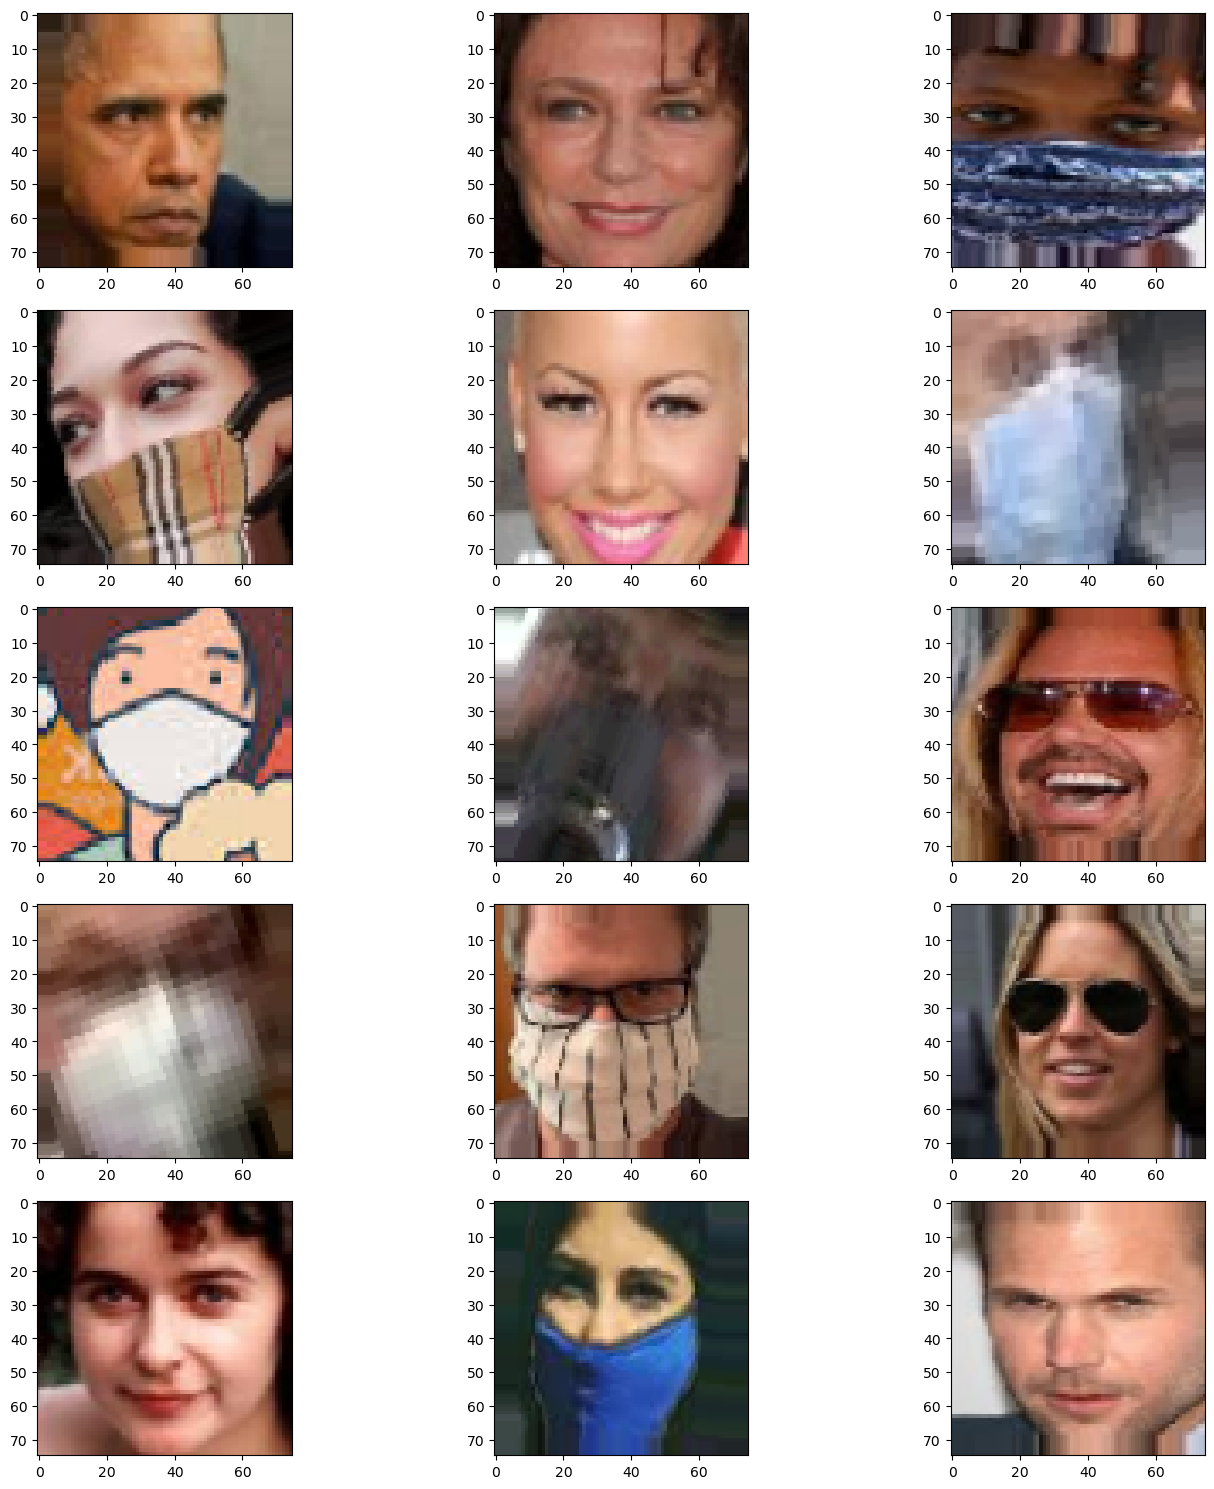

In [4]:
plt.figure(figsize=(15, 15))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in training_set:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [5]:
model = Sequential()
def add_layer(model ,filters, width , height , dropout_n):
    model.add(Conv2D(filters, 3,input_shape = (width, height, 3), activation = 'relu'))
    model.add(BatchNormalization())
    # 2- pooling image
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(dropout_n))
    return model
def heddinLayer(model,units,dropout_n ):
    model.add(Dense(units = units, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_n))
    return model
def compileModel(model, num_of_heddin ,dropout_n ,activation , loss ):
    model.add(Flatten())
    for i in range(0,num_of_heddin):
        units = int(input("enter the units layer : "))
        heddinLayer(model, units, dropout_n)
    model.add(Dense(units = 1, activation =activation ))
    # Compiling the CNN
    model.compile(optimizer = 'adam', loss = loss, metrics = ['accuracy'])
    model.summary()
    return model

In [6]:
def Fitting(model , train, valiad , epoch , step_epoch , valid_step , callback):
    model.fit(train,
                steps_per_epoch = step_epoch,
                epochs = epoch,
                callbacks= callback,
                validation_data =  valiad,
                validation_steps= valid_step
        )
    return model
def callBack(patience):
    from keras.callbacks import EarlyStopping
    earlystop = EarlyStopping(patience=patience)
    callbacks = [earlystop]
    return callbacks

In [7]:
def mask_label(pred):
    if(pred>0.5):
        return 'NO MASK'
    else:
        return 'MASK'

In [8]:
add_layer(model, 32, w_h, w_h, 0.20)
add_layer(model, 64, w_h, w_h, 0.20)
add_layer(model, 64, w_h, w_h, 0.20)
compileModel(model,2, 0.50, 'sigmoid', 'binary_crossentropy')
callback = callBack(10)
step_epoch = len(training_set)//2
Fitting(model, training_set, valid_set, 15, step_epoch, 3, callback)

enter the units layer : 256
enter the units layer : 128
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 36, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 


In [9]:
model.save("mask_detection.h5")

In [10]:
evaluate = model.evaluate(test_set)

31/31 [==============================] - 3s 106ms/step - loss: 0.0609 - accuracy: 0.9839


1/1 [==============================] - 0s 230ms/step
MASK


array([[0.15888122]], dtype=float32)

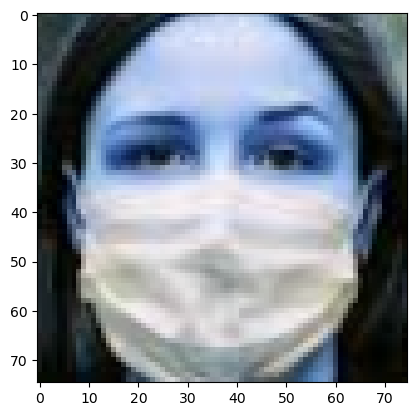

In [11]:
#mask
img =cv.imread('./46.png')
img = cv.resize(img,(w_h,w_h))
plt.imshow(img)
image = np.reshape(img,[1,w_h,w_h,3])
image = image/255.0
predict=model.predict(image)
print(mask_label(predict))
predict*10

1/1 [==============================] - 0s 31ms/step
MASK


array([[0.01778587]], dtype=float32)

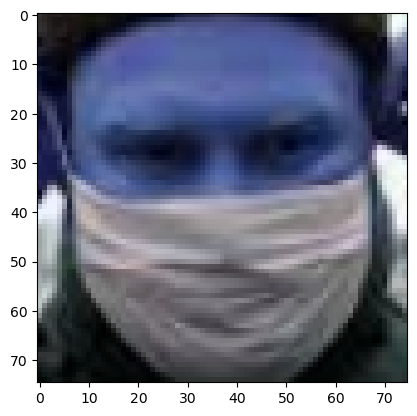

In [12]:
#mask
img =cv.imread('./152.png')
img = cv.resize(img,(w_h,w_h))
plt.imshow(img)
image = np.reshape(img,[1,w_h,w_h,3])
image = image/255.0
predict=model.predict(image)
print(mask_label(predict))
predict